In [1]:
import warnings
warnings.filterwarnings('ignore')

In [27]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
%matplotlib inline

# Needed for decision tree visualization
import pydotplus
from IPython.display import Image

In [125]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Read the CSV and Perform Basic Data Cleaning

In [4]:
# https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-

columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [6]:
# Load the data
file_path = Path('../Resources/LoanStats_2019Q1.csv.zip')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


In [17]:
# Copied code from credit_risk_resampling file to use the data that has already been cleaned with float values instead of strings.
binary_file_path = Path('../Resources/loans_data_encoded.csv')
binary_df = pd.read_csv(binary_file_path)
binary_df.reset_index(inplace=True, drop=True)
binary_df

,loan_amnt,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
0,10500.0,0.1719,375.35,66000.0,low_risk,27.24,0.0,0.0,8.0,0.0,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
1,25000.0,0.2000,929.09,105000.0,low_risk,20.23,0.0,0.0,17.0,1.0,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
2,20000.0,0.2000,529.88,56000.0,low_risk,24.26,0.0,0.0,8.0,0.0,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
3,10000.0,0.1640,353.55,92000.0,low_risk,31.44,0.0,1.0,10.0,1.0,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
4,22000.0,0.1474,520.39,52000.0,low_risk,18.76,0.0,1.0,14.0,0.0,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68812,10000.0,0.1502,346.76,26000.0,low_risk,9.60,0.0,0.0,9.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
68813,12000.0,0.2727,368.37,63000.0,low_risk,29.07,0.0,0.0,8.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
68814,5000.0,0.1992,185.62,52000.0,low_risk,14.86,0.0,0.0,5.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
68815,40000.0,0.0646,1225.24,520000.0,low_risk,9.96,0.0,1.0,21.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0


# Split the Data into Training and Testing

In [18]:
# Create our target loan_status to determine low or high risk
y = binary_df["loan_status"]

# Create our features: drop loan_status
X = binary_df.drop(columns="loan_status")

In [22]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.177238,1.0,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660,1.0,1.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.381873,0.0,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637,0.0,0.0
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.0
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.0
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0


In [23]:
# Check the balance of our target values
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [29]:
# Split the X and y into X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=44)

## Data Pre-Processing

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, you only scale the features data (`X_train` and `X_testing`).

In [30]:
# Create the StandardScaler instance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [31]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
X_scaler = scaler.fit(X_train)

In [32]:
# Scale the training and testing data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Print the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier onely, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [37]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

brf = BalancedRandomForestClassifier(bootstrap=True, class_weight=None,
                criterion='gini', max_depth=None, max_features='auto',
                max_leaf_nodes=None, min_impurity_decrease=0.0,
                min_samples_leaf=2, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                oob_score=False, random_state=1, replacement=False,
                sampling_strategy='auto', verbose=0, warm_start=False)
brf= brf.fit(X_train, y_train)
y_pred = brf.predict(X_test)

In [41]:
# Calculated the balanced accuracy score
y_pred = brf.predict(X_test)
balanced_accuracy_score(y_test, y_pred)


0.746219715956558

In [42]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[   65,    40],
       [ 2165, 14935]])

In [43]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.62      0.87      0.06      0.74      0.53       105
   low_risk       1.00      0.87      0.62      0.93      0.74      0.55     17100

avg / total       0.99      0.87      0.62      0.93      0.74      0.55     17205



In [122]:
# List the features sorted in descending order by feature importance
importances = brf.feature_importances_
importances_2 = sorted(zip(brf.feature_importances_, X.columns), reverse=True)
importances_2

[(0.10552775480112592, 'total_rec_prncp'),
 (0.06275162350999182, 'total_pymnt'),
 (0.057488081861383586, 'total_pymnt_inv'),
 (0.0545604869421768, 'total_rec_int'),
 (0.05055715264854201, 'last_pymnt_amnt'),
 (0.032080387016631365, 'int_rate'),
 (0.021431709365693802, 'issue_d_Jan-2019'),
 (0.018228325586423733, 'max_bal_bc'),
 (0.018214102922148697, 'revol_bal'),
 (0.01732434672202568, 'dti'),
 (0.01665318785350276, 'installment'),
 (0.016412199469452673, 'annual_inc'),
 (0.016055801472642527, 'mths_since_recent_inq'),
 (0.01590020447191283, 'out_prncp_inv'),
 (0.015808442640943735, 'total_bc_limit'),
 (0.015629568311977593, 'bc_util'),
 (0.015454367385795847, 'tot_hi_cred_lim'),
 (0.01515160867825035, 'total_rev_hi_lim'),
 (0.01488305884240664, 'tot_cur_bal'),
 (0.014109959935872374, 'mo_sin_old_il_acct'),
 (0.014042425028753218, 'mo_sin_old_rev_tl_op'),
 (0.012792839638052158, 'avg_cur_bal'),
 (0.012730337319839915, 'total_bal_il'),
 (0.012365073892734457, 'bc_open_to_buy'),
 (0.01

<AxesSubplot:title={'center':'Features Importances: Top 10'}, xlabel='Features'>

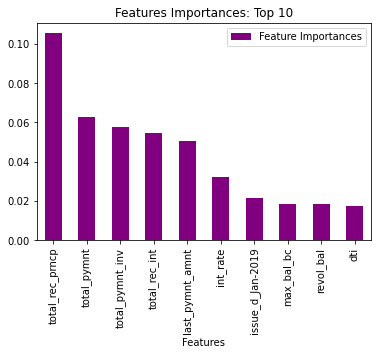

In [124]:
# Visualize the features by importance
importances_df = pd.DataFrame(importances_2)
importances_top10.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_top10 = importances_top10[0:10]

importances_top10.rename(columns={1: 'Features'}, inplace=True)
importances_top10.set_index(importances_top10['Features'], inplace=True)
importances_top10.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_top10.plot(
    kind='bar',
    title= 'Features Importances: Top 10',
    legend=True,
    color="purple",

)

### Easy Ensemble Classifier

In [126]:
# Train the EasyEnsembleClassifier
eec = EasyEnsembleClassifier(base_estimator=None, n_estimators=100, n_jobs=1,
            random_state=1, replacement=False, sampling_strategy='auto',
            verbose=0, warm_start=False)

eec= eec.fit(X_train, y_train)
y_pred = eec.predict(X_test)

In [127]:
# Calculated the balanced accuracy score
y_pred = eec.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.9115998329156223

In [128]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[   93,    12],
       [ 1069, 16031]])

In [129]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.08      0.89      0.94      0.15      0.91      0.83       105
   low_risk       1.00      0.94      0.89      0.97      0.91      0.83     17100

avg / total       0.99      0.94      0.89      0.96      0.91      0.83     17205

